# Customer Segmentation with K Means

Imagine that you have a customer dataset, and you need to apply customer segmentation on this historical data. Customer segmentation is the practice of partitioning a customer base into groups of individuals that have similar characteristics. It is a significant strategy as a business can target these specific groups of customers and effectively allocate marketing resources. For example, one group might contain customers who are high-profit and low-risk, that is, more likely to purchase products, or subscribe for a service. A business task is to retaining those customers. Another group might include customers from non-profit organizations, and so on.

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Get the data
Data Source: https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/Cust_Segmentation.csv

In [6]:
df = pd.read_csv('../Cust_Segmentation.csv')

In [7]:
df.head()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,Address,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,NBA001,6.3
1,2,47,1,26,100,4.582,8.218,0.0,NBA021,12.8
2,3,33,2,10,57,6.111,5.802,1.0,NBA013,20.9
3,4,29,2,4,19,0.681,0.516,0.0,NBA009,6.3
4,5,47,1,31,253,9.308,8.908,0.0,NBA008,7.2


As you can see, **Address** in this dataset is not numerical. K means algorithm isn't directly applicable to non numerical values because Euclidean distance function isn't really meaningful for that. So, let's drop this feature and run clustering.

In [8]:
df = df.drop('Address',axis=1)

In [9]:
df.head()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,6.3
1,2,47,1,26,100,4.582,8.218,0.0,12.8
2,3,33,2,10,57,6.111,5.802,1.0,20.9
3,4,29,2,4,19,0.681,0.516,0.0,6.3
4,5,47,1,31,253,9.308,8.908,0.0,7.2


In [11]:
#total rows and colums in the dataset
df.shape

(850, 9)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
Customer Id        850 non-null int64
Age                850 non-null int64
Edu                850 non-null int64
Years Employed     850 non-null int64
Income             850 non-null int64
Card Debt          850 non-null float64
Other Debt         850 non-null float64
Defaulted          700 non-null float64
DebtIncomeRatio    850 non-null float64
dtypes: float64(4), int64(5)
memory usage: 59.8 KB


In [39]:
df.isnull().sum()

Customer Id          0
Age                  0
Edu                  0
Years Employed       0
Income               0
Card Debt            0
Other Debt           0
Defaulted          150
DebtIncomeRatio      0
dtype: int64

Missing Defaulted values will be replaced by 0 latter.

#### Data visualizations

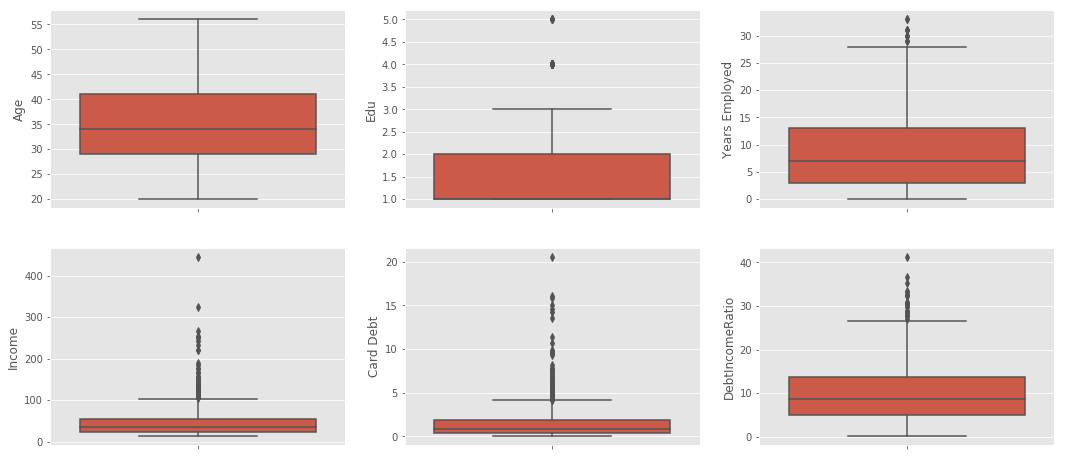

In [23]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)
sns.boxplot(df['Age'],orient='v',ax=ax1)
sns.boxplot(df['Edu'],orient='v',ax=ax2)
sns.boxplot(df['Years Employed'],orient='v',ax=ax3)
sns.boxplot(df['Income'],orient='v',ax=ax4)
sns.boxplot(df['Card Debt'],orient='v',ax=ax5)
sns.boxplot(df['DebtIncomeRatio'],orient='v',ax=ax6)

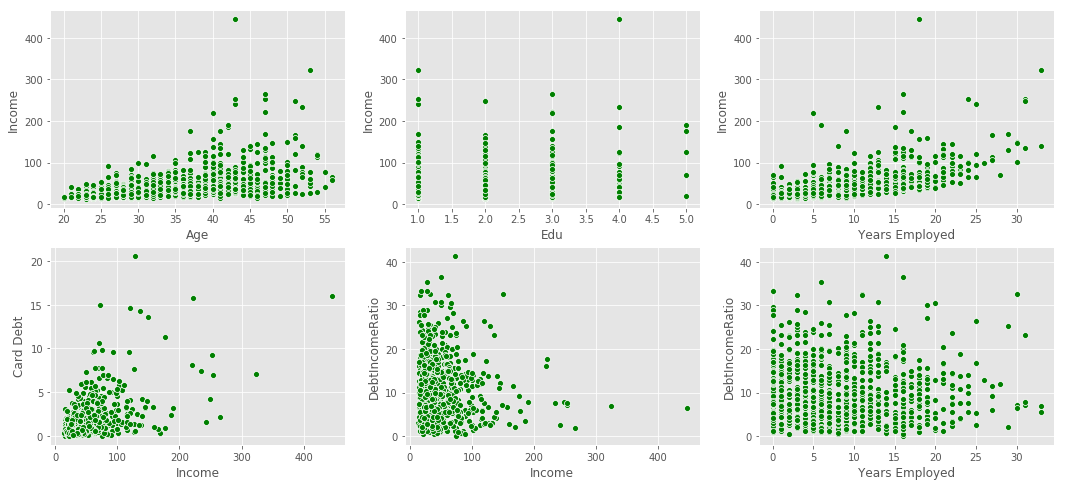

In [35]:
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

sns.scatterplot(x=df['Age'],y=df['Income'],ax=ax1,color='g')
sns.scatterplot(x=df['Edu'],y=df['Income'],ax=ax2,color='g')
sns.scatterplot(x=df['Years Employed'],y=df['Income'],ax=ax3,color='g')
sns.scatterplot(x=df['Income'],y=df['Card Debt'],ax=ax4,color='g')
sns.scatterplot(x=df['Income'],y=df['DebtIncomeRatio'],ax=ax5,color='g')
sns.scatterplot(x=df['Years Employed'],y=df['DebtIncomeRatio'],ax=ax6,color='g')

### Feature sleection for the model
Let's drop customer ID from the features and then normalize.

Normalization is a statistical method that helps mathematical-based algorithms to interpret features with different magnitudes and distributions equally. We use StandardScaler() to normalize our dataset.

In [36]:
from sklearn.preprocessing import StandardScaler
X = df.values[:,1:]

Let's now put 0 in missing Defaulted  values

In [38]:
X = np.nan_to_num(X)

In [40]:
norm_feat = StandardScaler().fit_transform(X)

In [41]:
norm_feat

array([[ 0.74291541,  0.31212243, -0.37878978, ..., -0.59048916,
        -0.52379654, -0.57652509],
       [ 1.48949049, -0.76634938,  2.5737211 , ...,  1.51296181,
        -0.52379654,  0.39138677],
       [-0.25251804,  0.31212243,  0.2117124 , ...,  0.80170393,
         1.90913822,  1.59755385],
       ...,
       [-1.24795149,  2.46906604, -1.26454304, ...,  0.03863257,
         1.90913822,  3.45892281],
       [-0.37694723, -0.76634938,  0.50696349, ..., -0.70147601,
        -0.52379654, -1.08281745],
       [ 2.1116364 , -0.76634938,  1.09746566, ...,  0.16463355,
        -0.52379654, -0.2340332 ]])

**Let's utilize Elbow method to decide the number of cluster.**

In [52]:
from sklearn.cluster import KMeans
distortion = []
K = range(1,11)

for k in K:
    kmeanModel=KMeans(n_clusters=k, init='k-means++', random_state=0).fit(X)
    kmeanModel.fit(X)
    distortion.append(kmeanModel.inertia_)

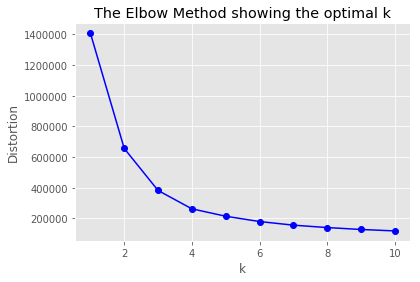

In [57]:
plt.plot(K, distortion, 'bo-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

**k = 4 is the good choice!** 

Let's now use k=4 and perform our clustering.

In [58]:
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=12)

In [59]:
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=12, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [62]:
labels = kmeans.labels_
print(labels)

[1 3 0 1 2 0 0 0 1 3 0 1 1 1 1 1 1 1 0 1 1 1 1 0 3 0 1 1 0 1 3 0 1 1 1 1 1
 1 1 3 1 3 1 3 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 0 0 3 1
 1 1 0 1 3 0 0 0 3 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 3 0 0 1 0 1 1 0 0 0
 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1
 1 1 1 1 1 1 0 1 3 3 1 0 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 3 1
 1 1 1 1 0 1 1 0 1 0 1 1 0 2 1 3 1 1 1 1 0 1 2 3 1 1 0 0 0 1 1 0 0 0 0 1 3
 1 1 1 1 3 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 3 0 0 1 1 1 1 1 1 0 1 1 1 1
 1 1 0 0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 3 3 1 3 1 0 1 3 0 1 1 1 1 1 1
 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 3 0 0 3 1
 1 0 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 3 1 1 1 1 1 3 1 1 1 3 1 1 1 0 1 0 3 3 0
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 3 1 0 1 1 1 1 0 1 1 1 1 1 3 1 1 1 1 1 1 1 0 1
 0 3 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 2
 0 1 0 0 0 1 0 1 1 1 3 1 1 1 1 0 1 3 1 1 1 1 0 1 0 0 0 1 0 3 0 1 0 1 1 1 0
 1 0 1 1 1 1 3 1 1 1 0 1 

#### Insights

In [63]:
df['clus_label'] = labels

In [64]:
df.head()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,clus_label
0,1,41,2,6,19,0.124,1.073,0.0,6.3,1
1,2,47,1,26,100,4.582,8.218,0.0,12.8,3
2,3,33,2,10,57,6.111,5.802,1.0,20.9,0
3,4,29,2,4,19,0.681,0.516,0.0,6.3,1
4,5,47,1,31,253,9.308,8.908,0.0,7.2,2


In [68]:
kmeans.cluster_centers_

array([[3.97590909e+01, 1.80909091e+00, 1.29227273e+01, 6.29000000e+01,
        2.32304545e+00, 4.46300909e+00, 1.68181818e-01, 1.07327273e+01],
       [3.20660714e+01, 1.61071429e+00, 5.45892857e+00, 2.80767857e+01,
        9.28905357e-01, 1.89449107e+00, 2.46428571e-01, 1.01078571e+01],
       [4.66000000e+01, 2.30000000e+00, 2.12000000e+01, 2.70900000e+02,
        7.88400000e+00, 1.33752000e+01, 3.00000000e-01, 8.21000000e+00],
       [4.34166667e+01, 2.18333333e+00, 1.94833333e+01, 1.23400000e+02,
        3.83666667e+00, 7.34046667e+00, 8.33333333e-02, 9.03666667e+00]])

We can easily check the centroid values by averaging the features in each cluster.

In [67]:
df.groupby('clus_label').mean()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
clus_label,,,,,,,,,
0,411.262443,39.764706,1.805430,12.923077,62.814480,2.312855,4.445878,0.203297,10.691855
1,433.456172,32.050089,1.611807,5.445438,28.048301,0.930440,1.896669,0.296774,10.122898
2,453.500000,46.600000,2.300000,21.200000,270.900000,7.884000,13.375200,0.428571,8.210000
3,399.150000,43.416667,2.183333,19.483333,123.400000,3.836667,7.340467,0.108696,9.036667


Now, lets look at the distribution of customers based on their age, education and income.

Text(0, 0.5, 'Income')

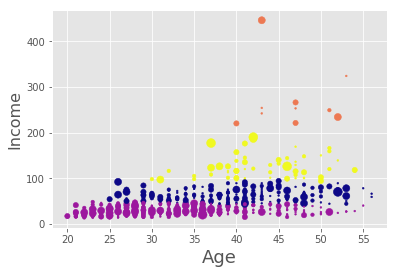

In [104]:
area = np.pi *(X[:,1])**2
plt.scatter(X[:,0],X[:,3],s=area,c=kmeans.labels_,cmap='plasma')
plt.xlabel('Age', fontsize=18)
plt.ylabel('Income', fontsize=16)

We group the clusters as:

- (Oragne) High Income, Educated, Old Aged 
- (Yellow) Middle Income, Middle Aged
- (Blue)   Low Income, Middle Aged
- (Purple) Very Low Income, Young Aged

In [91]:
from mpl_toolkits.mplot3d import Axes3D

Text(0.5, 0, 'Income')

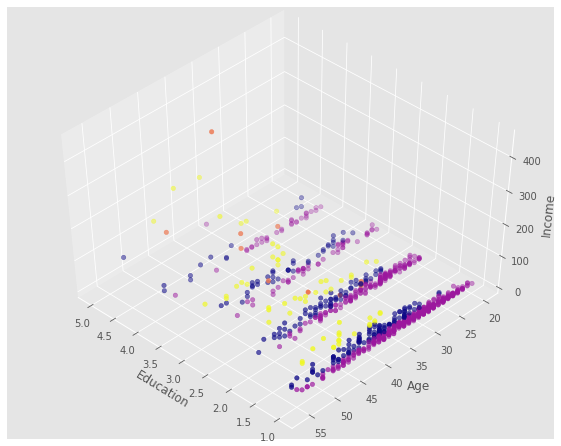

In [103]:
fig = plt.figure(figsize=(8,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(X[:, 1], X[:, 0], X[:, 3], c= kmeans.labels_,cmap='plasma')
ax.set_xlabel('Education')
ax.set_ylabel('Age')
ax.set_zlabel('Income')